In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *


In [3]:
url = URLs.IMAGENETTE_160

In [4]:
path = untar_data(url)
Path.basepath = path

In [5]:
Path.BASE_PATH = path

In [6]:
(path).ls()

(#4) [Path('train'),Path('.DS_Store'),Path('noisy_imagenette.csv'),Path('val')]

In [7]:
(path/'train').ls(), (path/'val').ls()

((#11) [Path('train/n03888257'),Path('train/n02979186'),Path('train/n02102040'),Path('train/n01440764'),Path('train/n03445777'),Path('train/n03028079'),Path('train/n03425413'),Path('train/n03000684'),Path('train/n03417042'),Path('train/n03394916')...],
 (#10) [Path('val/n03888257'),Path('val/n02979186'),Path('val/n02102040'),Path('val/n01440764'),Path('val/n03445777'),Path('val/n03028079'),Path('val/n03425413'),Path('val/n03000684'),Path('val/n03417042'),Path('val/n03394916')])

In [8]:
(path/'train/n03888257').ls()

(#960) [Path('train/n03888257/n03888257_15527.JPEG'),Path('train/n03888257/n03888257_1389.JPEG'),Path('train/n03888257/n03888257_38685.JPEG'),Path('train/n03888257/n03888257_48334.JPEG'),Path('train/n03888257/n03888257_18464.JPEG'),Path('train/n03888257/n03888257_10106.JPEG'),Path('train/n03888257/n03888257_15826.JPEG'),Path('train/n03888257/n03888257_20717.JPEG'),Path('train/n03888257/n03888257_17269.JPEG'),Path('train/n03888257/n03888257_18687.JPEG')...]

In [3]:
def get_data(path, presize, resize, bs):
  dblock = DataBlock(
      blocks=(ImageBlock, CategoryBlock),
      get_items = get_image_files,
      splitter = GrandparentSplitter(train_name='train', valid_name='val'),
      get_y = parent_label,
      # transforms on cpu, resize images
      item_tfms = Resize(presize),
      # transforms on gpu, random resize crop and normalize with dataset normalization stats
      batch_tfms = [*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)]
  )

  return dblock.dataloaders(path, bs=bs)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


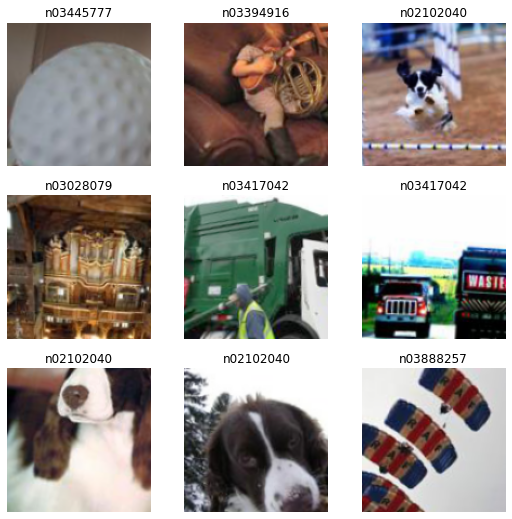

In [10]:
dls = get_data(path, 160, 128, 64)
dls.show_batch()

In [4]:
# create functions for the block, getting the model, and getting the learner

# create a first block as a normal conv layer with stride 2
def block(ch_in, ch_out): return ConvLayer(ch_in, ch_out, stride=2)

def get_model(n_out):
  model = nn.Sequential(
      # start with colour images with 3 channels, go to 16 output channels (skip 4 and 8) since 4 reduces the info too much and 8 does not learn sufficiently (9 sizes kernel -> 8 activations is bad)
      block(3, 16),
      block(16, 32),
      block(32, 64),
      block(64, 128),
      block(128, 256),
      # use average pooling on the 256 channels to reduce the grid activations to 1x1
      nn.AdaptiveAvgPool2d(1),
      # flatten the final grid activations
      Flatten(),
      # use a final dense layer from 256 -> desired size
      nn.Linear(256, n_out)
  )

  return model

In [5]:
def get_learner(model):
  # create a categorial learner with cross entropy loss and reduce the floating point to fp16 in order to speed up training
  learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy]).to_fp16()
  return learn

In [25]:
# get the number of classes from the data loader
dls_out = dls.c
learn = get_learner(get_model(dls_out))
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.871281,2.084309,0.357962,00:37
1,1.497042,1.574310,0.497834,00:37
2,1.295508,1.288464,0.582166,00:37
3,1.184200,1.205397,0.618599,00:37
4,1.122276,1.185691,0.619873,00:38


In [26]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.106927,1.189355,0.619363,00:39
1,1.095756,1.163037,0.627771,00:38
2,1.081228,1.121325,0.643567,00:38
3,1.070021,1.116005,0.645096,00:39
4,1.067769,1.129573,0.637452,00:38


## Resnets
- Experiment with skip connections and make a resnet block

In [6]:
def res_conv_block(ch_in, ch_out, stride):
  conv_block = nn.Sequential(
      # first layer applies a change in channel and stride
      ConvLayer(ch_in, ch_out, stride=stride),
      # second layer has no activation function and initializes gamma=0 in batch norm to 'ease optimization at the start of training'
      ConvLayer(ch_out, ch_out, act_cls=None, norm_type=NormType.BatchZero)
  )
  return conv_block


In [7]:
class ResBlock(Module):
  def __init__(self, ch_in, ch_out, stride):
    self.convs = res_conv_block(ch_in, ch_out, stride)
    # deal with change in the number of channels in self.convs by using 1x1 convolutions
    self.change_channels = noop if ch_in==ch_out else ConvLayer(ch_in, ch_out, ks=1, act_cls=None)
    # deal with change in the side of grid activations in self.convs using average pooling with ks=2
    self.change_stride = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

  
  def forward(self, x):
    # apply relu since we deal with the entire block as a unit
    return F.relu(self.change_channels(self.change_stride(x)) + self.convs(x))

In [33]:
def block(ch_in, ch_out): 
  stride = 2
  return ResBlock(ch_in, ch_out, stride)

learn = get_learner(get_model(dls_out))

In [35]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.051138,2.034911,0.320255,00:42
1,2.012704,1.995784,0.333503,00:41
2,1.987364,1.964597,0.338344,00:41
3,1.967176,1.953426,0.346497,00:41
4,1.962309,1.951412,0.345987,00:41


## State of the art ResNet
- Apply new architecture techniques to improve resnet

In [8]:
# create the resnet stem

# resnet stem allows for the first layers to be very fast since the first layers have the most computation, while later layers have more parameters
# resnets can have up to 3 convolutions layers in a single resnet block, so to avoid all this computation, the stem will be made of simple convolutional layers

def resnet_stem(*sizes):
  # use the list of sizes to build a stem with the corresponding output sizes and a max pooling layer at the end
  stem = [
      *[ConvLayer(sizes[i], sizes[i+1], stride = 2 if i == 0 else 1) for i in range(len(sizes) - 1)],
       nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]

  return stem

In [9]:
stem = resnet_stem(3, 32, 32, 64)
stem

[ConvLayer(
   (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), ConvLayer(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), ConvLayer(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)]

In [10]:
class ResNet(nn.Sequential):
  # get the number if outputs and sizes of resnet block layers
  def __init__(self, n_out, layers, expansion=1):
    stem = resnet_stem(3, 32, 32, 64)
    # create the number of parameters for each resnet (the number of input and output channels for each resnet block)
    self.block_channel_sizes = [64, 64, 128, 256, 512]
    # expand the blocks by the expansion size
    if expansion != 1:
      # expand the sizes of all but the first channel size
      for i in range(1, len(self.block_channel_sizes)):
        self.block_channel_sizes[i] *= expansion
    
    blocks = [self._make_layer(i, layer) for i, layer in enumerate(layers)]
    
    # use nn.Sequential's constructor to create the resnet
    super().__init__(
        *stem,
        *blocks,
        # flatten the layer to make this a fully convolutional network
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        # create a final dense layer with number of outputs to number of classes
        nn.Linear(self.block_channel_sizes[-1], n_out)
    )

  def _make_layer(self, idx, n_layers):
    # use stride=1 for first layer since stem ends in a kernel size 2 max pooling layer, else stride=2
    stride = 1 if idx == 0 else 2
    # get the input and output block sizes according to the index of the current layer
    ch_in, ch_out = self.block_channel_sizes[idx: idx+2]
    layer = nn.Sequential(
        # make sure first layer in resblock changes channel sizes and reduces the grid activation size (stride = 2)
        *[ResBlock(ch_in if i == 0 else ch_out, ch_out, stride if i == 0 else 1)
        for i in range(n_layers)]
    )
    return layer

In [44]:
dls_out = dls.c
rn = ResNet(dls_out, [2,2,2,2])

In [ ]:
rn

In [46]:
learn_2 = get_learner(rn)
learn_2.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.243933,2.185940,0.247643,01:06
1,2.057438,2.009035,0.323567,01:05
2,1.942175,1.929757,0.358217,01:06
3,1.895939,1.896821,0.374777,01:05
4,1.885815,1.892212,0.376815,01:06


## Bottleneck layers
- Use more channels but reduce block computation by scaing down channels, then using the conv layer with kernel size 3x3, then scaling inputs back up
- More channels allowed in the same amount of time

In [11]:
# change the conv block definition for the ResBlock module
def res_conv_block(ch_in, ch_out, stride):
  block = nn.Sequential(
      # 1x1 conv to reduce grid size by 4
      ConvLayer(ch_in, ch_out//4, 1),
      # ConvLayer with kernel sizes of 3x3 to do the work
      ConvLayer(ch_out//4, ch_out//4, stride=stride),
      # final 1x1 conv layer to scale channels back up. Also not activaiton (since it will be after this layer) and set batch norm to start at 0 for better training
      ConvLayer(ch_out//4, ch_out, 1, act_cls=None, norm_type=NormType.BatchZero)
  )

  return block

In [12]:
url_path = untar_data(URLs.IMAGENETTE_320)

In [13]:
dls = get_data(url_path, presize=160, resize=128, bs=128)
dls_out = dls.c
# since the bottle neck layers reduce the filter sizes by 4 in the res_conv_layers, set expansion=4
rn = ResNet(dls_out, [3, 4, 6, 3], expansion=4)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [14]:
rn

ResNet(
  (0): ConvLayer(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): ResBlock(
      (convs): Sequential(
        (0): ConvLayer(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

In [15]:
learn_3 = get_learner(rn)
learn_3.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.683515,1.716492,0.440510,01:54
1,1.401857,2.154489,0.430573,01:55
2,1.226529,2.004723,0.460637,01:54
3,1.085185,1.736101,0.489172,01:53
4,0.954200,1.041292,0.668790,01:54
5,0.832967,0.907768,0.707771,01:54
6,0.732076,0.879012,0.710828,01:54
7,0.653393,0.748342,0.766624,01:54
8,0.579748,0.640992,0.794904,01:54
9,0.536275,0.619861,0.800000,01:54


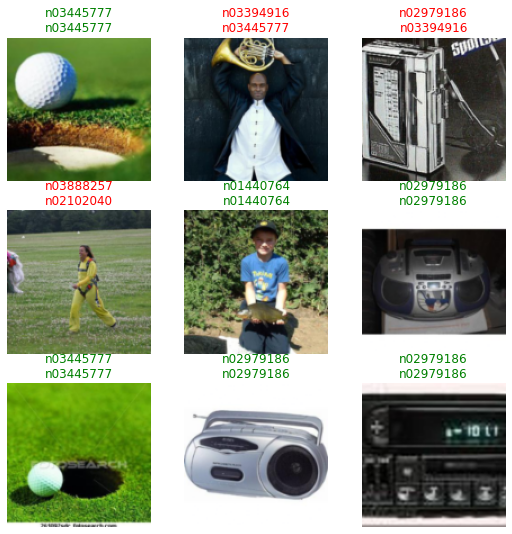

In [18]:
learn_3.show_results()